<a href="https://colab.research.google.com/github/simonzalan/vitmav45-nagyhazi/blob/main/VItmav45_Nagyhazi_2_milestone_CNN_ipynb_m%C3%A1solata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Getting image datasets from the MVTEC website

In [ ]:
import os
os.system("wget https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938113-1629952094/mvtec_anomaly_detection.tar.xz -O mvtec_anomaly_detection.tar.xz")
os.system("tar -xf mvtec_anomaly_detection.tar.xz")

0

In [ ]:
import os
!ls /content/carpet/train/good
os.system("mkdir mappa")
!ls /content/carpet/test


000.png  032.png  064.png  096.png  128.png  160.png  192.png  224.png	256.png
001.png  033.png  065.png  097.png  129.png  161.png  193.png  225.png	257.png
002.png  034.png  066.png  098.png  130.png  162.png  194.png  226.png	258.png
003.png  035.png  067.png  099.png  131.png  163.png  195.png  227.png	259.png
004.png  036.png  068.png  100.png  132.png  164.png  196.png  228.png	260.png
005.png  037.png  069.png  101.png  133.png  165.png  197.png  229.png	261.png
006.png  038.png  070.png  102.png  134.png  166.png  198.png  230.png	262.png
007.png  039.png  071.png  103.png  135.png  167.png  199.png  231.png	263.png
008.png  040.png  072.png  104.png  136.png  168.png  200.png  232.png	264.png
009.png  041.png  073.png  105.png  137.png  169.png  201.png  233.png	265.png
010.png  042.png  074.png  106.png  138.png  170.png  202.png  234.png	266.png
011.png  043.png  075.png  107.png  139.png  171.png  203.png  235.png	267.png
012.png  044.png  076.png  108.png  140.png  172.png

Installing library for easy splitting of the downloaded dataset

In [ ]:
os.system("pip install split-folders")

0

Creating a validation image batch from the training batch

In [ ]:

import splitfolders
splitfolders.ratio("/content/carpet/train", output="output1", seed=1337, ratio=(.9,0.1)) 
splitfolders.ratio("/content/carpet/test/", output="output1", seed=1337, ratio=(.9,0.1)) 

Copying files: 280 files [00:02, 121.16 files/s]
Copying files: 117 files [00:02, 46.76 files/s]


Checking if the images are in their places

In [ ]:
!ls /content/output1/val


color  cut  good  hole	metal_contamination  thread


Testing if the images are where they need to be

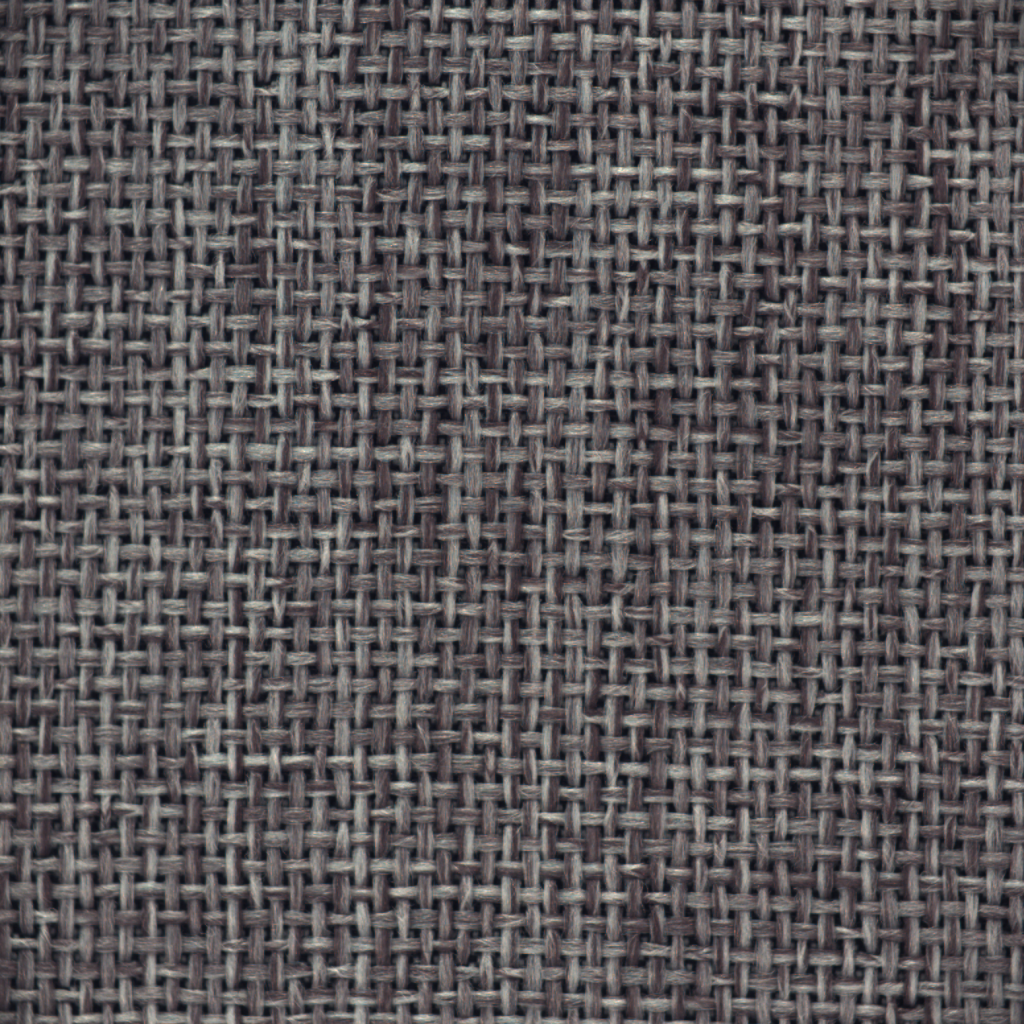

In [ ]:
from IPython.display import Image
Image("/content/carpet/train/good/009.png")


Importing libraries that will be used later

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D, UpSampling2D, BatchNormalization, Conv2DTranspose
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Loading the images into variables(training, testinf and validation)

In [ ]:
image_size = 512
batch_size = 16
num_classes = 6

datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    '/content/output1/train/',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='input'
    )

validation_generator = datagen.flow_from_directory(
    '/content/output1/val/',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = datagen.flow_from_directory(
    '/content/carpet/test/',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='input'
    )

train_ds = image_dataset_from_directory("/content/output1/train/", 
                                        label_mode='categorical',
                                        image_size=(image_size, image_size),
                                        batch_size=batch_size)
val_ds = image_dataset_from_directory("/content/output1/val/",
                                      label_mode='categorical',
                                      image_size=(image_size, image_size),
                                      batch_size=batch_size)
test_ds = image_dataset_from_directory("/content/carpet/test/",
                                      label_mode='categorical',
                                      image_size=(image_size, image_size),
                                      batch_size=batch_size)




Found 332 images belonging to 6 classes.
Found 41 images belonging to 6 classes.
Found 117 images belonging to 6 classes.
Found 332 files belonging to 6 classes.
Found 41 files belonging to 6 classes.
Found 117 files belonging to 6 classes.


Checking if the images are all the same size

In [ ]:
from PIL import Image
import os.path

files = os.listdir("/content/output1/val/good/")
same_size = True
for f in files:
    filename = "/content/output1/val/good/" + f
    im = Image.open(filename)
    #print(im.size)
    if im.size != (1024, 1024):
        print("NOT OK")
        same_size = False

print(same_size)
print(train_ds.snapshot)

run_id = 0


True
<bound method DatasetV2.snapshot of <BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>>


In [ ]:
# előtanított modell betöltése, a fully-connected rétegek nélkül
base_model = ResNet50(weights='imagenet', include_top=False) # Érdemes kipróbálni előtanított súlyok betöltése nélkül(weights=None)!

# az utolsó konvolúciós réteg utána egy global average pooling réteget teszünk, ez rögtön "lapítja" (flatten) a 2D konvolúciót
x = base_model.output
x = GlobalAveragePooling2D()(x)
# ezután hozzáadunk egy előrecsatolt réteget ReLU aktivációs függvénnyel
x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
# és végül egy kimenete lesz a hálónak - a "binary_crossentropy" költségfüggvénynek erre van szüksége
predictions = Dense(num_classes, activation='softmax')(x)

for layer in base_model.layers[:171]:
    layer.trainable = False
    
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001), metrics=['accuracy'])


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
tensorboard_callback = TensorBoard(log_dir=f"./logs/{run_id:04d}", update_freq=100)
run_id += 1

network_history = model.fit(train_ds, 
                            epochs=5, 
                            verbose=1,
                            validation_data=val_ds,
                            callbacks=[tensorboard_callback])

Epoch 1/5
21/21 [==============================] - 343s 16s/step - loss: 1.1795 - accuracy: 0.6928 - val_loss: 0.9965 - val_accuracy: 0.7561
Epoch 2/5
21/21 [==============================] - 335s 16s/step - loss: 0.7724 - accuracy: 0.7741 - val_loss: 0.8765 - val_accuracy: 0.7561
Epoch 3/5
21/21 [==============================] - 340s 16s/step - loss: 0.6645 - accuracy: 0.7831 - val_loss: 0.7741 - val_accuracy: 0.7561
Epoch 4/5
21/21 [==============================] - 381s 18s/step - loss: 0.6006 - accuracy: 0.8042 - val_loss: 0.7853 - val_accuracy: 0.7561
Epoch 5/5
21/21 [==============================] - 366s 17s/step - loss: 0.5625 - accuracy: 0.7982 - val_loss: 0.7290 - val_accuracy: 0.7561


In [ ]:
from tqdm.notebook import tqdm
preds = []
targets = []
for x, y in tqdm(val_ds):
    preds.extend(model.predict(x))
    targets.extend(y)

  0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 8s 8s/step


In [ ]:

preds = np.array(preds).squeeze()
targets = np.array(targets)
print(preds.shape)
print(targets.shape)

preds = np.argmax(preds, axis=1)
targets = np.argmax(targets, axis=1)
print(preds.shape)
print(targets.shape)

(41, 6)
(41, 6)
(41,)
(41,)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
conf=confusion_matrix(targets, preds)

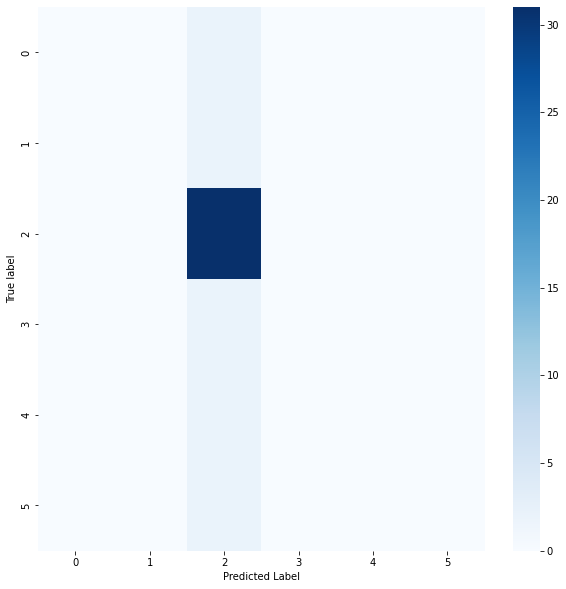

In [ ]:
import seaborn as sns; #sns.set()
plt.figure(figsize=(10,10))
ax = sns.heatmap(conf, annot=False, fmt='d', cmap=plt.cm.Blues)
ax.set(xlabel='Predicted Label',
       ylabel='True label');

Examine the reconstruction error between our validation data (good/normal images) and the anomaly images